In [2]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
sys.path.append(os.path.abspath("../..")) 
from src.training.train import train_autoencoder, train_cellfate
from sklearn.model_selection import train_test_split
from src.models.classifier import mlp_classifier
import tensorflow as tf
from src.evaluation.evaluate import shapiro_wilk_test, plot_qq_plots
from sklearn.metrics import confusion_matrix
from src.preprocessing.preprocessing_functions import augment_dataset, augmentations

# DISCOVER results (fate predictions)

In [11]:
y_test = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/data/final_split/y_test.npy")

## Load trained DISCOVER results
augmented_x_train = np.load('../../data/final_split/augmented_x_train.npy')
augmented_y_train = np.load('../../data/final_split/augmented_y_train.npy')

y_pred_discover42 = np.load("/Users/inescunha/Desktop/AI4CellFate/DISCOVER_results/42_test_z_scores.npy")
y_pred_discover43 = np.load("/Users/inescunha/Desktop/AI4CellFate/DISCOVER_results/43_test_z_scores.npy")
y_pred_discover44 = np.load("/Users/inescunha/Desktop/AI4CellFate/DISCOVER_results/44_test_z_scores.npy")

y_pred_discover42_classes = (y_pred_discover42>0.5).astype("int32")
y_pred_discover43_classes = (y_pred_discover43>0.5).astype("int32")
y_pred_discover44_classes = (y_pred_discover44>0.5).astype("int32")

cm_discover42 = confusion_matrix(y_test, y_pred_discover42_classes)
cm_discover_norm_42 = cm_discover42/cm_discover42.sum(axis=1, keepdims=True)
cm_discover43 = confusion_matrix(y_test, y_pred_discover43_classes)
cm_discover_norm_43 = cm_discover43/cm_discover43.sum(axis=1, keepdims=True)
cm_discover44= confusion_matrix(y_test, y_pred_discover44_classes)
cm_discover_norm_44 = cm_discover44/cm_discover44.sum(axis=1, keepdims=True)

confusion_matrices_discover = np.stack([cm_discover_norm_42, cm_discover_norm_43, cm_discover_norm_44], axis=0)

In [12]:
confusion_matrices_discover

array([[[0.36206897, 0.63793103],
        [0.37777778, 0.62222222]],

       [[0.70258621, 0.29741379],
        [0.68888889, 0.31111111]],

       [[0.76724138, 0.23275862],
        [0.71111111, 0.28888889]]])

In [10]:
precision_discover = np.zeros((confusion_matrices_discover.shape[0]))
accuracy_discover = np.zeros((confusion_matrices_discover.shape[0]))
false_positives_discover = np.zeros((confusion_matrices_discover.shape[0]))
false_negatives_discover = np.zeros((confusion_matrices_discover.shape[0]))

for size in range(confusion_matrices_discover.shape[0]):
    conf_matrix = confusion_matrices_discover[size]
    precision_discover[size] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
    accuracy_discover[size] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
    false_positives_discover[size] = conf_matrix[1,0] #/ np.sum(conf_matrix[1,:])
    false_negatives_discover[size] = conf_matrix[0,1] #/ np.sum(conf_matrix[0,:])

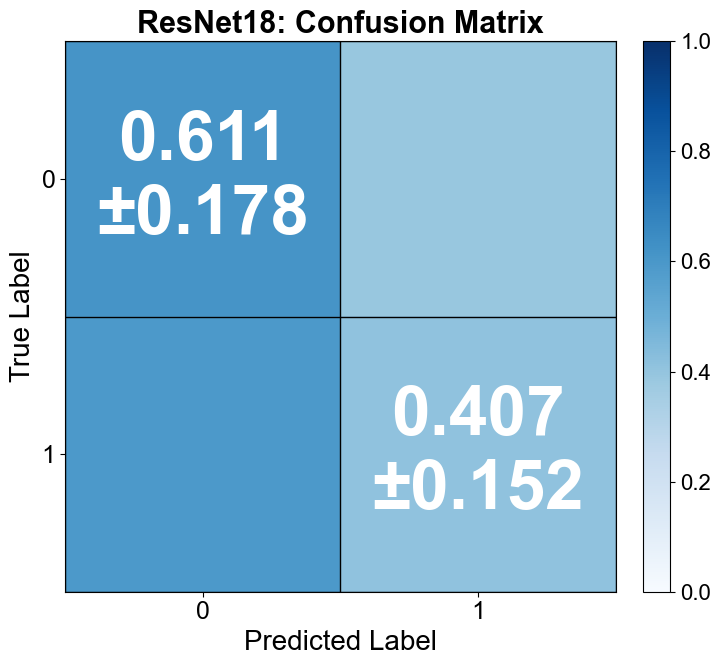

In [17]:
# Annotated mean confusion matrix with ± std (across 3 seeds)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Compute mean and std across seeds
mean_cm = np.mean(confusion_matrices_discover, axis=0)
std_cm = np.std(confusion_matrices_discover, axis=0)

# Use Arial and larger fonts
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(mean_cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)

# Title and labels
ax.set_title('ResNet18: Confusion Matrix', fontsize=22, fontweight='bold')
num_classes = mean_cm.shape[0]
ax.set_xlabel('Predicted Label', fontsize=20)
ax.set_ylabel('True Label', fontsize=20)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([str(i) for i in range(num_classes)], fontsize=18)
ax.set_yticklabels([str(i) for i in range(num_classes)], fontsize=18)

# Grid lines for clarity
ax.set_xticks(np.arange(-0.5, num_classes, 1), minor=True)
ax.set_yticks(np.arange(-0.5, num_classes, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
ax.tick_params(which='minor', bottom=False, left=False)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)

# Annotate ONLY diagonal cells with mean ± std in WHITE
for i in range(num_classes):
    for j in range(num_classes):
        if i == j:  # Only show values on the diagonal
            text = f"{mean_cm[i, j]:.3f}\n±{std_cm[i, j]:.3f}"
            ax.text(j, i, text, ha='center', va='center', color='white', fontsize=50, fontweight='bold')

plt.tight_layout()
#plt.savefig("discover_conf_matrix.eps", dpi=300, bbox_inches="tight")
plt.show()

7 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


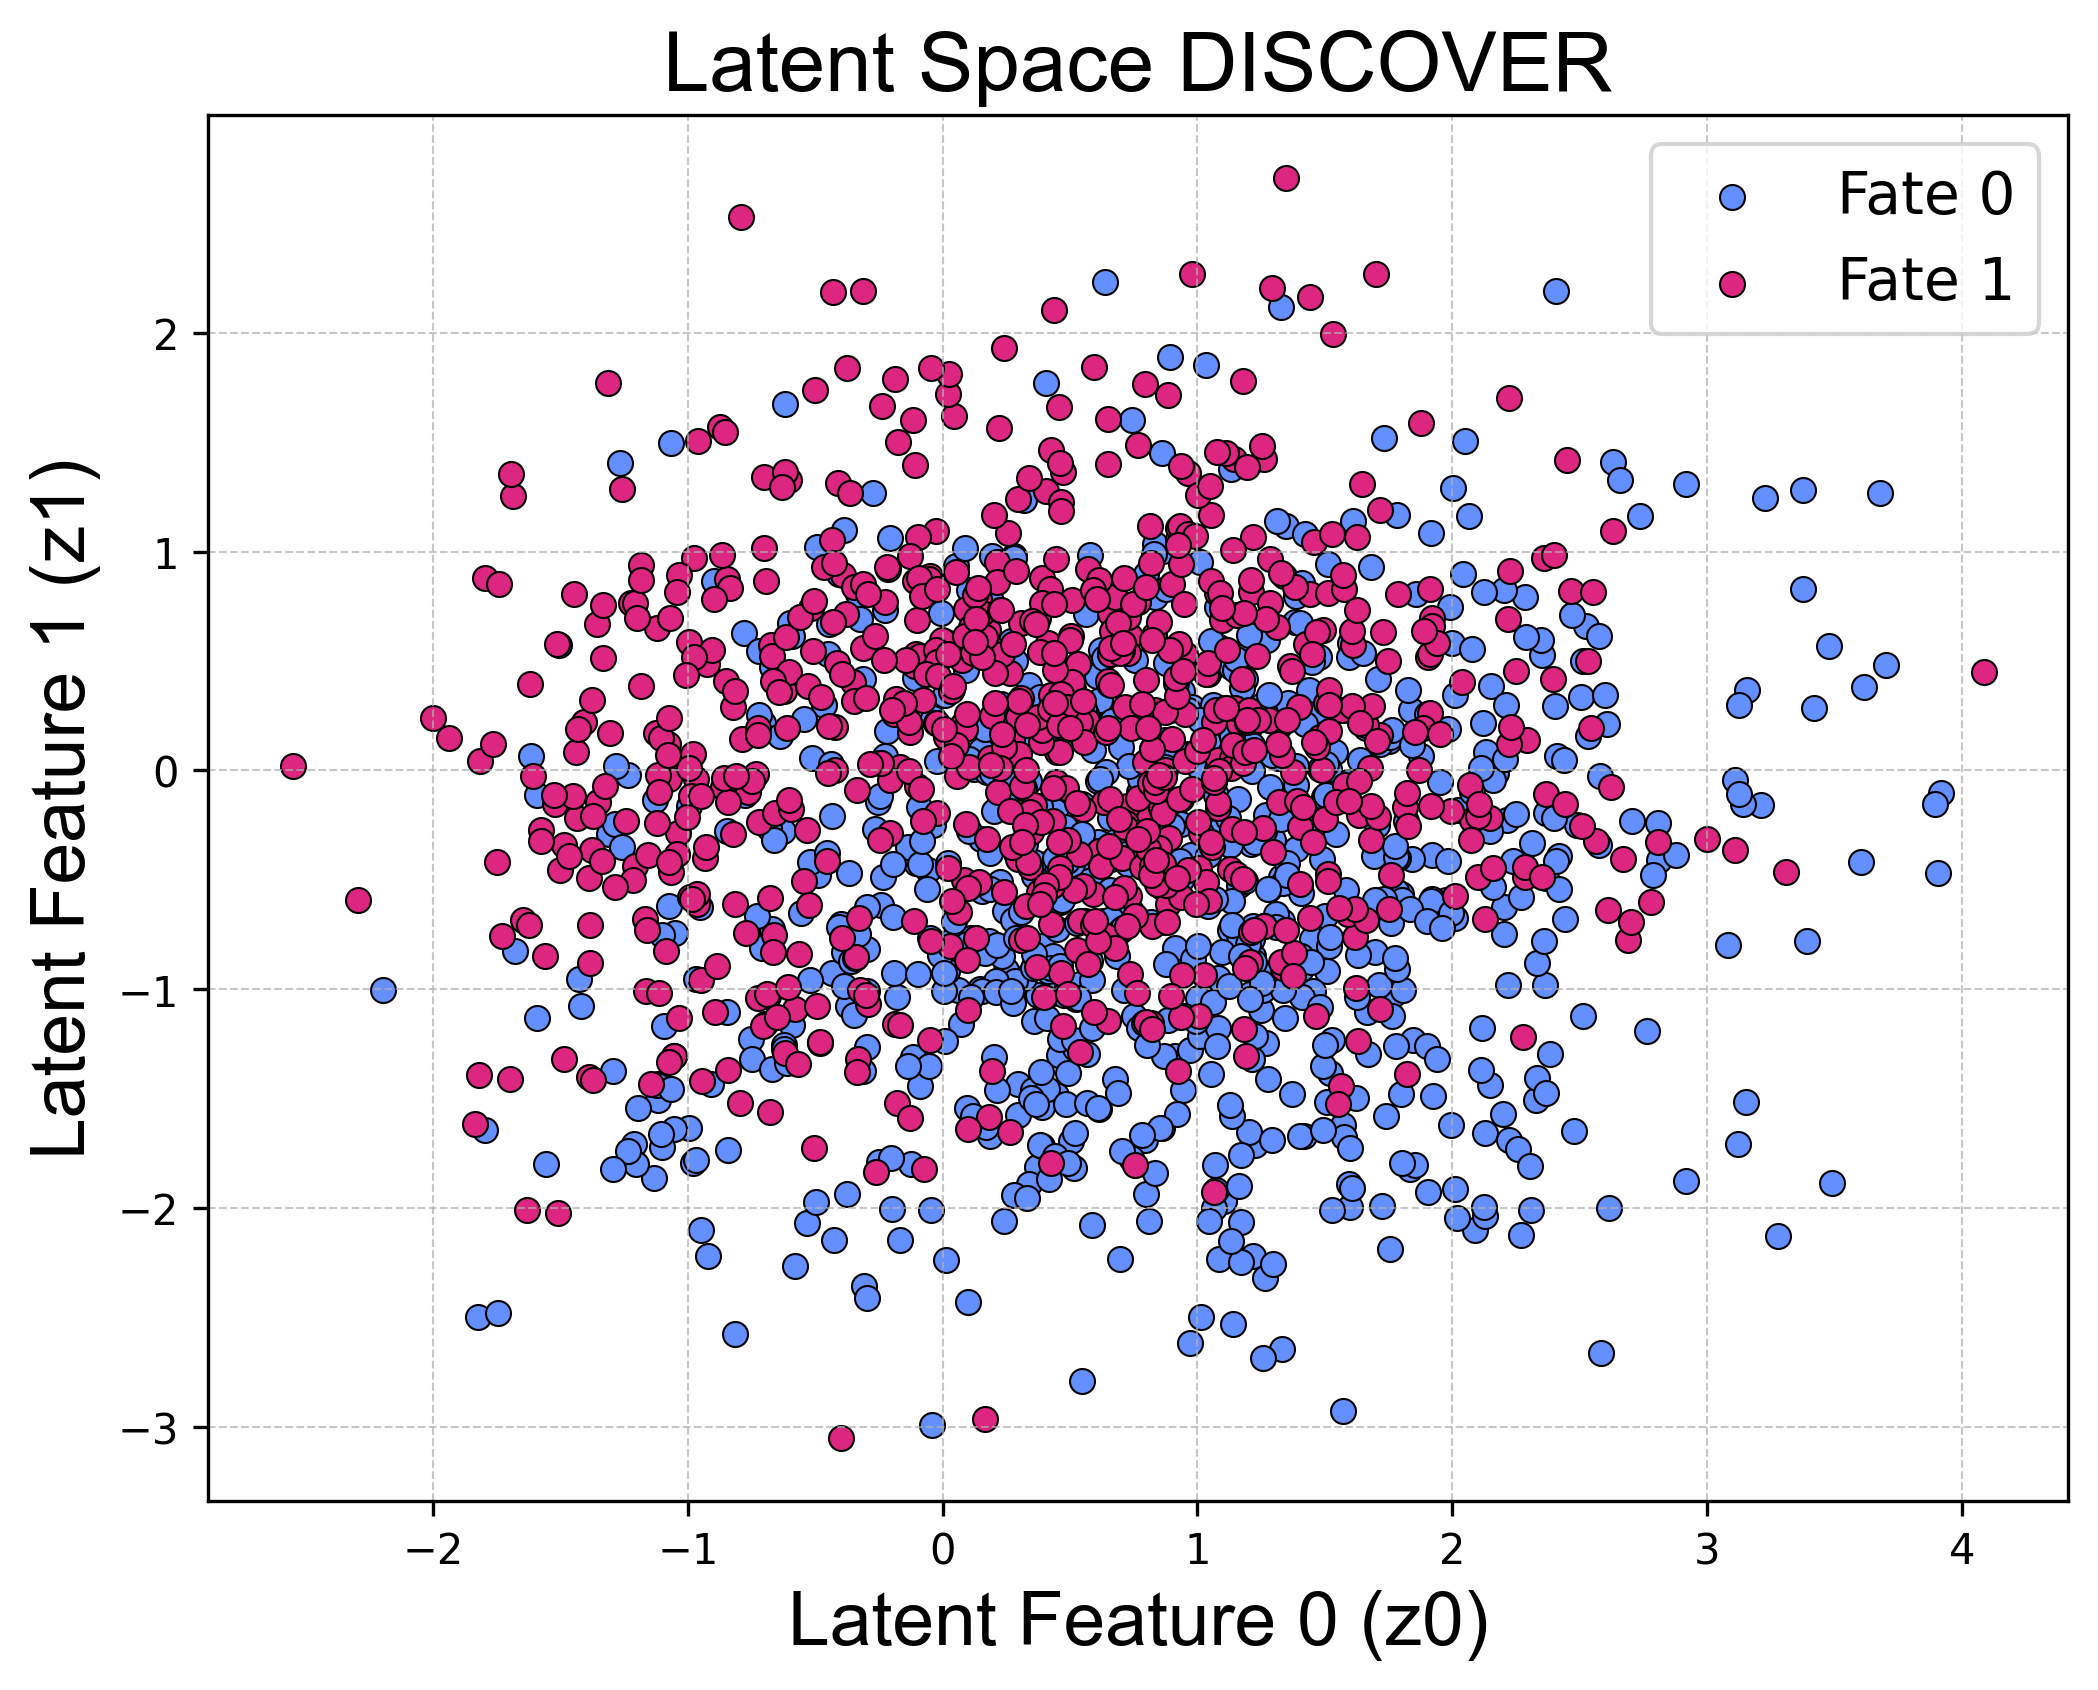

In [ ]:
# Predict the latent representations
latent_space = np.load("/Users/inescunha/Desktop/AI4CellFate/DISCOVER_results/44_train_latent_space.npy")

cor_vals = [np.corrcoef(np.eye(2)[augmented_y_train][:, 0], latent_space[:, i])[0, 1] for i in range(latent_space.shape[1])]
cor_vals = np.array(cor_vals)
feat_0, feat_1 = np.argsort(np.abs(cor_vals))[-2:]
print(feat_0, feat_1)
# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately with thin gray edges
plt.scatter(latent_space[augmented_y_train == 0][:, feat_0], latent_2d[augmented_y_train == 0][:, feat_1], 
            color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_2d[augmented_y_train == 1][:, feat_0], latent_2d[augmented_y_train == 1][:, feat_1], 
            color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Set axis limits
# plt.xlim(-4, 4)
# plt.ylim(-3, 4.5)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space DISCOVER", fontsize=20, fontname="Arial")

# Legend and grid
plt.legend(fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

#plt.savefig("latentspace_discover.eps", dpi=600, bbox_inches="tight")
plt.show()

# tau-VAE 


## Single-frame study

In [22]:
latent_space = np.load("/Users/inescunha/Desktop/AI4CellFate/tau_VAE_results/Single_frame/train_latent_2d.npy")
train_labels = np.load("/Users/inescunha/Desktop/AI4CellFate/tau_VAE_results/Single_frame/train_labels.npy")

0 1


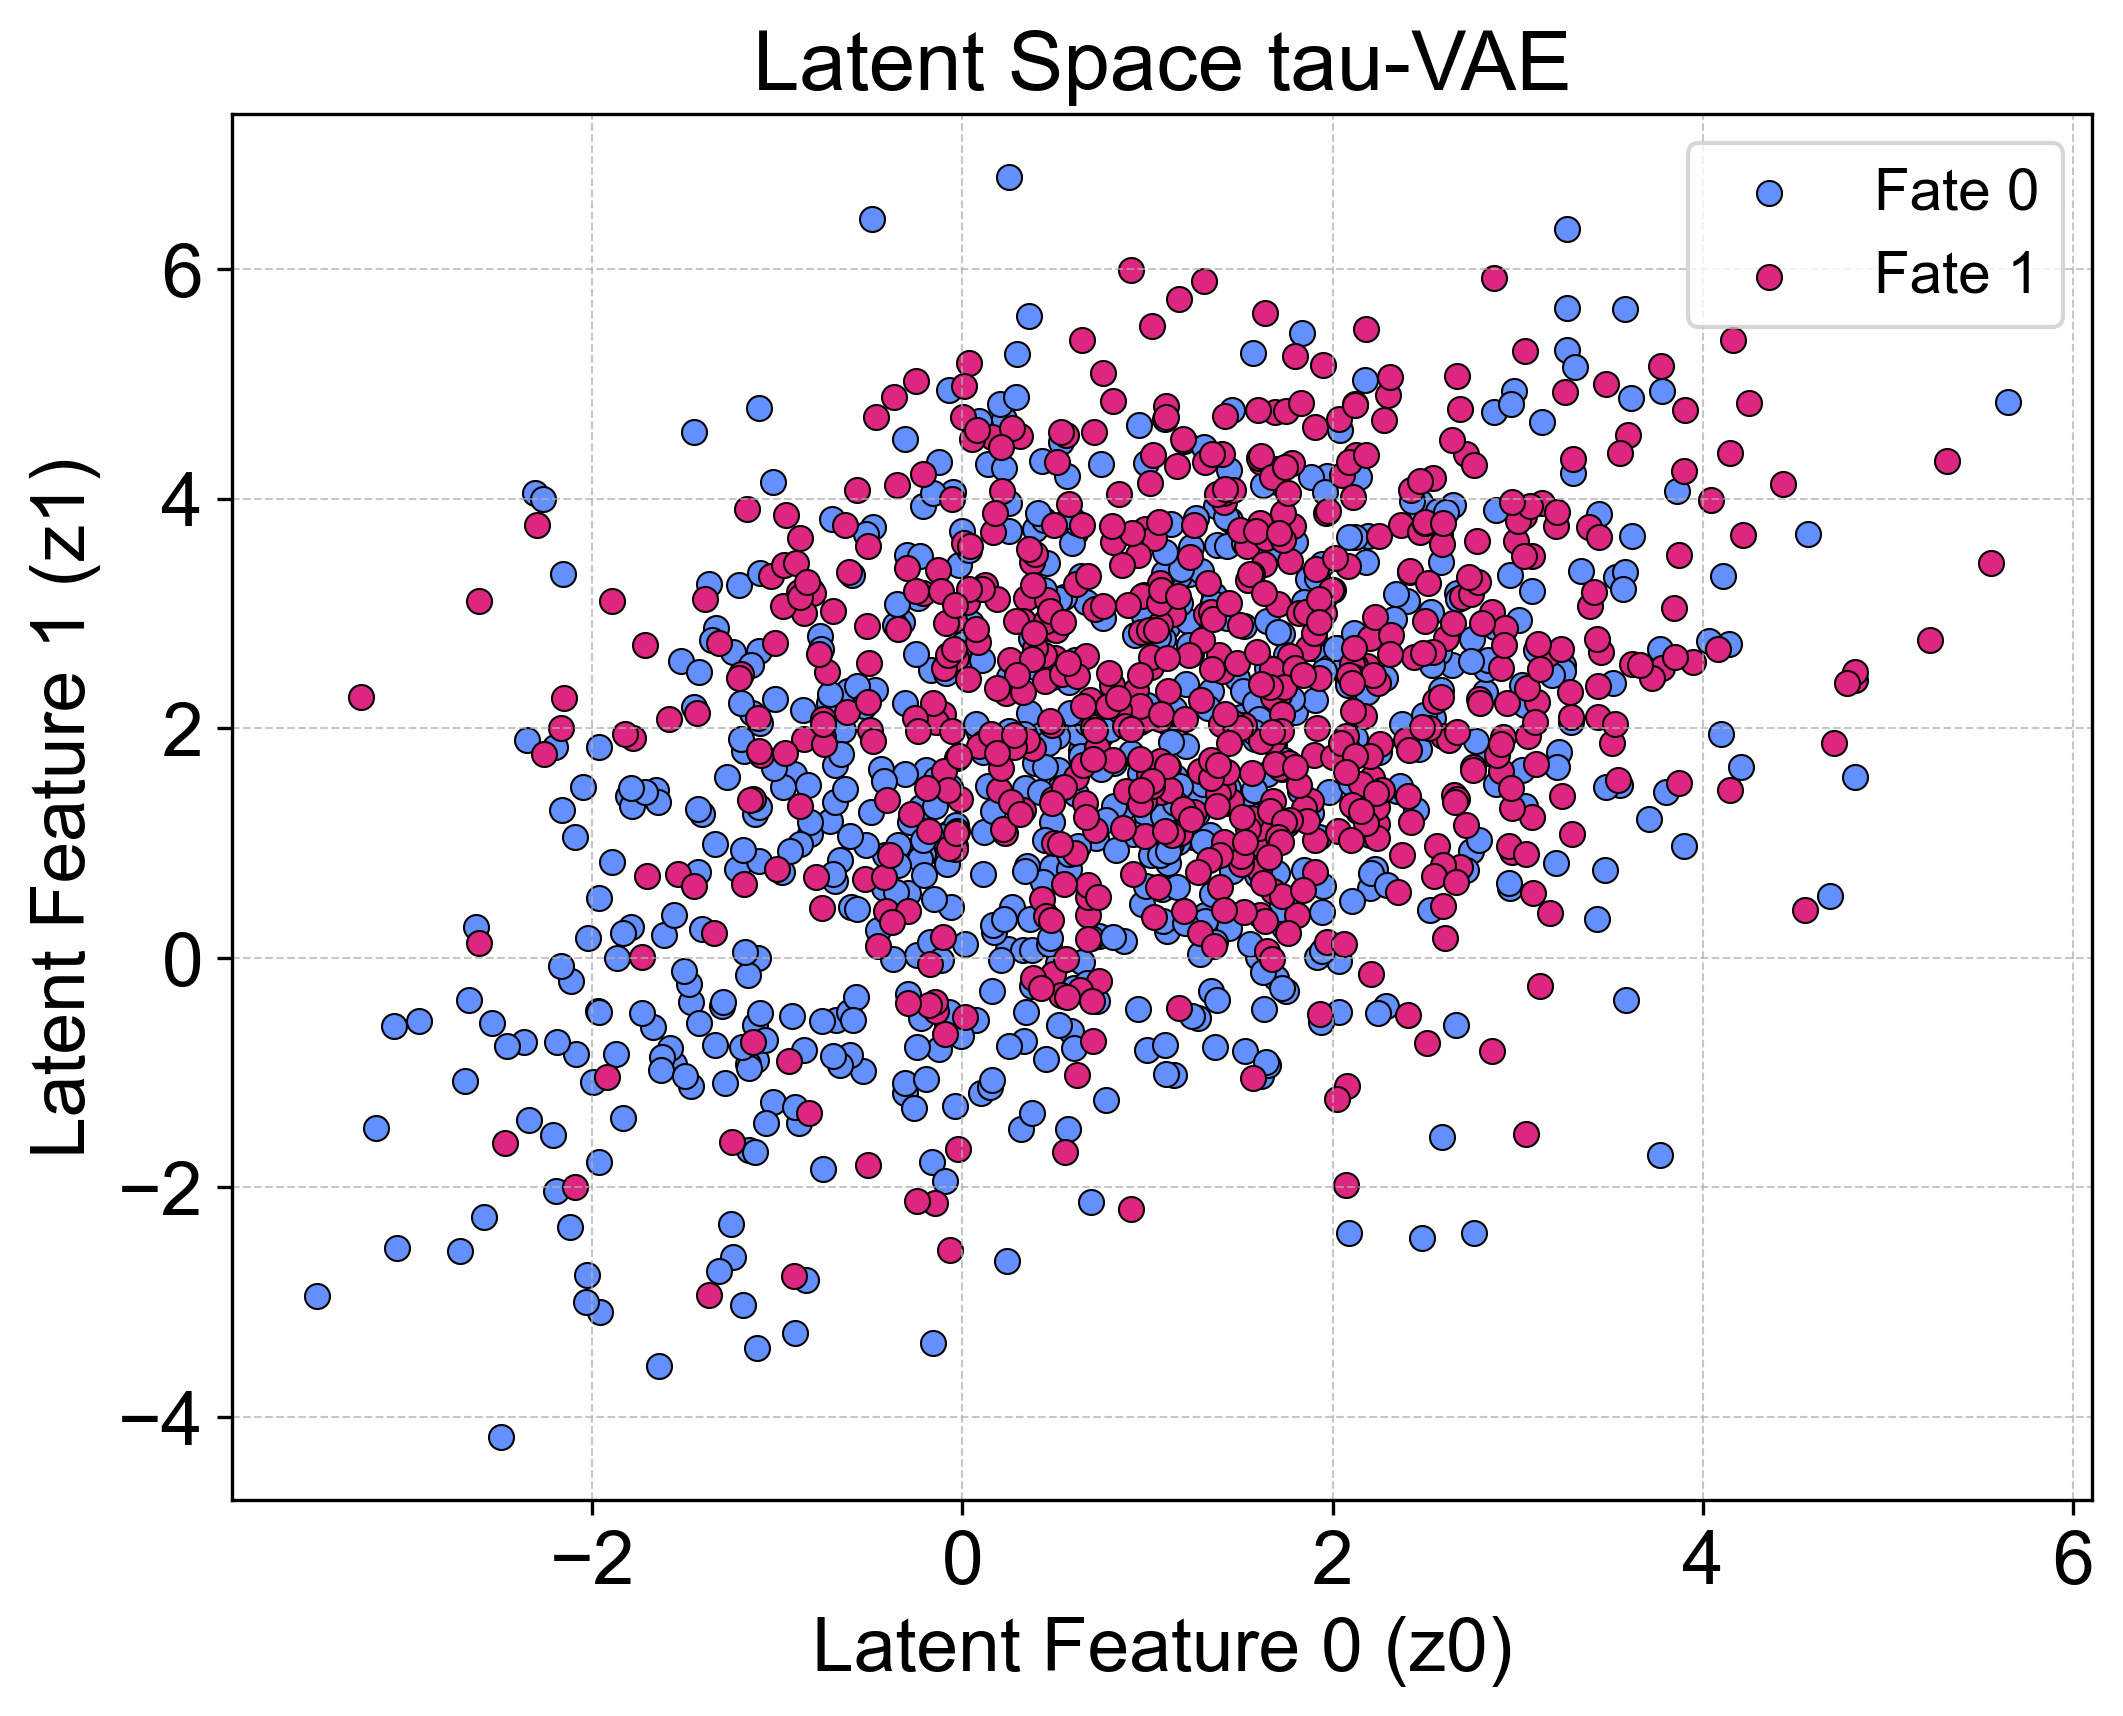

In [ ]:
cor_vals = [np.corrcoef(np.eye(2)[train_labels][:, 0], latent_space[:, i])[0, 1] for i in range(latent_space.shape[1])]
cor_vals = np.array(cor_vals)
feat_0, feat_1 = np.argsort(np.abs(cor_vals))[-2:]
print(feat_0, feat_1)
# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately with thin gray edges
plt.scatter(latent_space[train_labels == 0][:, feat_0], latent_space[train_labels == 0][:, feat_1], 
            color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_space[train_labels == 1][:, feat_0], latent_space[train_labels == 1][:, feat_1], 
            color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Set axis limits
# plt.xlim(-4, 4)
# plt.ylim(-3, 4.5)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space tau-VAE", fontsize=20, fontname="Arial")

# Legend and grid
plt.legend(fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

#plt.savefig("latentspace_tau_vae.eps", dpi=600, bbox_inches="tight")
plt.show()

In [3]:
tauvae_single_seed42 = np.load("/Users/inescunha/Desktop/AI4CellFate/tau_VAE_results/Single_frame/SINGLE_FRAME_42_confusion_matrix.npy")
tauvae_single_seed43 = np.load("/Users/inescunha/Desktop/AI4CellFate/tau_VAE_results/Single_frame/SINGLE_FRAME_43_confusion_matrix.npy")
tauvae_single_seed44 = np.load("/Users/inescunha/Desktop/AI4CellFate/tau_VAE_results/Single_frame/SINGLE_FRAME_44_confusion_matrix.npy")

conf_matrix_tauvae_single = np.stack([tauvae_single_seed42, tauvae_single_seed43, tauvae_single_seed44], axis=0)

## Full movie (from 0% to 100% normalised cell time)

In [5]:
tauvae_movie_seed42 = np.load("/Users/inescunha/Desktop/AI4CellFate/tau_VAE_results/Full_movie/movie_42_confusion_matrix.npy")
tauvae_movie_seed43 = np.load("/Users/inescunha/Desktop/AI4CellFate/tau_VAE_results/Full_movie/movie_43_confusion_matrix.npy")
tauvae_movie_seed44 = np.load("/Users/inescunha/Desktop/AI4CellFate/tau_VAE_results/Full_movie/movie_44_confusion_matrix.npy")

conf_matrix_tauvae_movie = np.stack([tauvae_movie_seed42, tauvae_movie_seed43, tauvae_movie_seed44], axis=0)

# Comparing ALL results (final)

In [ ]:
## AI4CellFate

ai4cellfate_seed42 = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/results/s1_ep35_lr5_la1_seed42_ldim2_s2_lr6_la4_lc1_lcon8/confusion_matrix_values_epoch_52.npy")
ai4cellfate_seed44 = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/results/s1_ep35_lr5_la1_seed48_ldim2_s2_lr6_la4_lc1_lcon8/confusion_matrix_values_epoch_53.npy")
ai4cellfate_seed46 = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/results/s1_ep35_lr5_la1_seed46_ldim2_s2_lr6_la4_lc1_lcon8/confusion_matrix_values_epoch_50.npy")

conf_matrix_ai4cellfate = np.stack([ai4cellfate_seed42, ai4cellfate_seed44, ai4cellfate_seed46], axis=0)

## Best performing ImageNet (VGG16)

imagenet_seed42 = np.load("imagenet_conf_matrix_seed42.npy")
imagenet_seed44 = np.load("imagenet_conf_matrix_seed44.npy")
imagenet_seed46 = np.load("imagenet_conf_matrix_seed46.npy")

conf_matrix_imagenet = np.stack([imagenet_seed42, imagenet_seed44, imagenet_seed46], axis=0)

## Tabular
conf_matrix_tabular = np.load("conf_matrix_tabular_13_features.npy")

In [13]:
precision_tabular = np.zeros((conf_matrix_tabular.shape[0]))
precision_ai4cellfate = np.zeros((conf_matrix_ai4cellfate.shape[0]))
precision_imagenet = np.zeros((conf_matrix_imagenet.shape[0]))
precision_discover = np.zeros((confusion_matrices_discover.shape[0]))
precision_tauvae_single = np.zeros((conf_matrix_tauvae_single.shape[0]))
precision_tauvae_movie = np.zeros((conf_matrix_tauvae_movie.shape[0]))

for seed in range(conf_matrix_tabular.shape[0]):
    conf_matrix = conf_matrix_tabular[seed]
    precision_tabular[seed] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
    precision_ai4cellfate[seed] = conf_matrix_ai4cellfate[seed][0,0] / (conf_matrix_ai4cellfate[seed][0,0] + conf_matrix_ai4cellfate[seed][1,0])
    precision_imagenet[seed] = conf_matrix_imagenet[seed][0,0] / (conf_matrix_imagenet[seed][0,0] + conf_matrix_imagenet[seed][1,0])
    precision_discover[seed] = confusion_matrices_discover[seed][0,0] / (confusion_matrices_discover[seed][0,0] + confusion_matrices_discover[seed][1,0])
    precision_tauvae_single[seed] = conf_matrix_tauvae_single[seed][0,0] / (conf_matrix_tauvae_single[seed][0,0] + conf_matrix_tauvae_single[seed][1,0])
    precision_tauvae_movie[seed] = conf_matrix_tauvae_movie[seed][0,0] / (conf_matrix_tauvae_movie[seed][0,0] + conf_matrix_tauvae_movie[seed][1,0])

In [15]:
accuracy_tabular = np.zeros((conf_matrix_tabular.shape[0]))
accuracy_ai4cellfate = np.zeros((conf_matrix_ai4cellfate.shape[0]))
accuracy_imagenet = np.zeros((conf_matrix_imagenet.shape[0]))
accuracy_discover = np.zeros((confusion_matrices_discover.shape[0]))
accuracy_tauvae_single = np.zeros((conf_matrix_tauvae_single.shape[0]))
accuracy_tauvae_movie = np.zeros((conf_matrix_tauvae_movie.shape[0]))

for seed in range(conf_matrix_tabular.shape[0]):
    conf_matrix = conf_matrix_tabular[seed]
    accuracy_tabular[seed] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
    accuracy_ai4cellfate[seed] = (conf_matrix_ai4cellfate[seed][0,0] + conf_matrix_ai4cellfate[seed][1,1]) / np.sum(conf_matrix_ai4cellfate[seed])
    accuracy_imagenet[seed] = (conf_matrix_imagenet[seed][0,0] + conf_matrix_imagenet[seed][1,1]) / np.sum(conf_matrix_imagenet[seed])
    accuracy_discover[seed] = (confusion_matrices_discover[seed][0,0] + confusion_matrices_discover[seed][1,1]) / np.sum(confusion_matrices_discover[seed])
    accuracy_tauvae_single[seed] = (conf_matrix_tauvae_single[seed][0,0] + conf_matrix_tauvae_single[seed][1,1]) / np.sum(conf_matrix_tauvae_single[seed])
    accuracy_tauvae_movie[seed] = (conf_matrix_tauvae_movie[seed][0,0] + conf_matrix_tauvae_movie[seed][1,1]) / np.sum(conf_matrix_tauvae_movie[seed])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


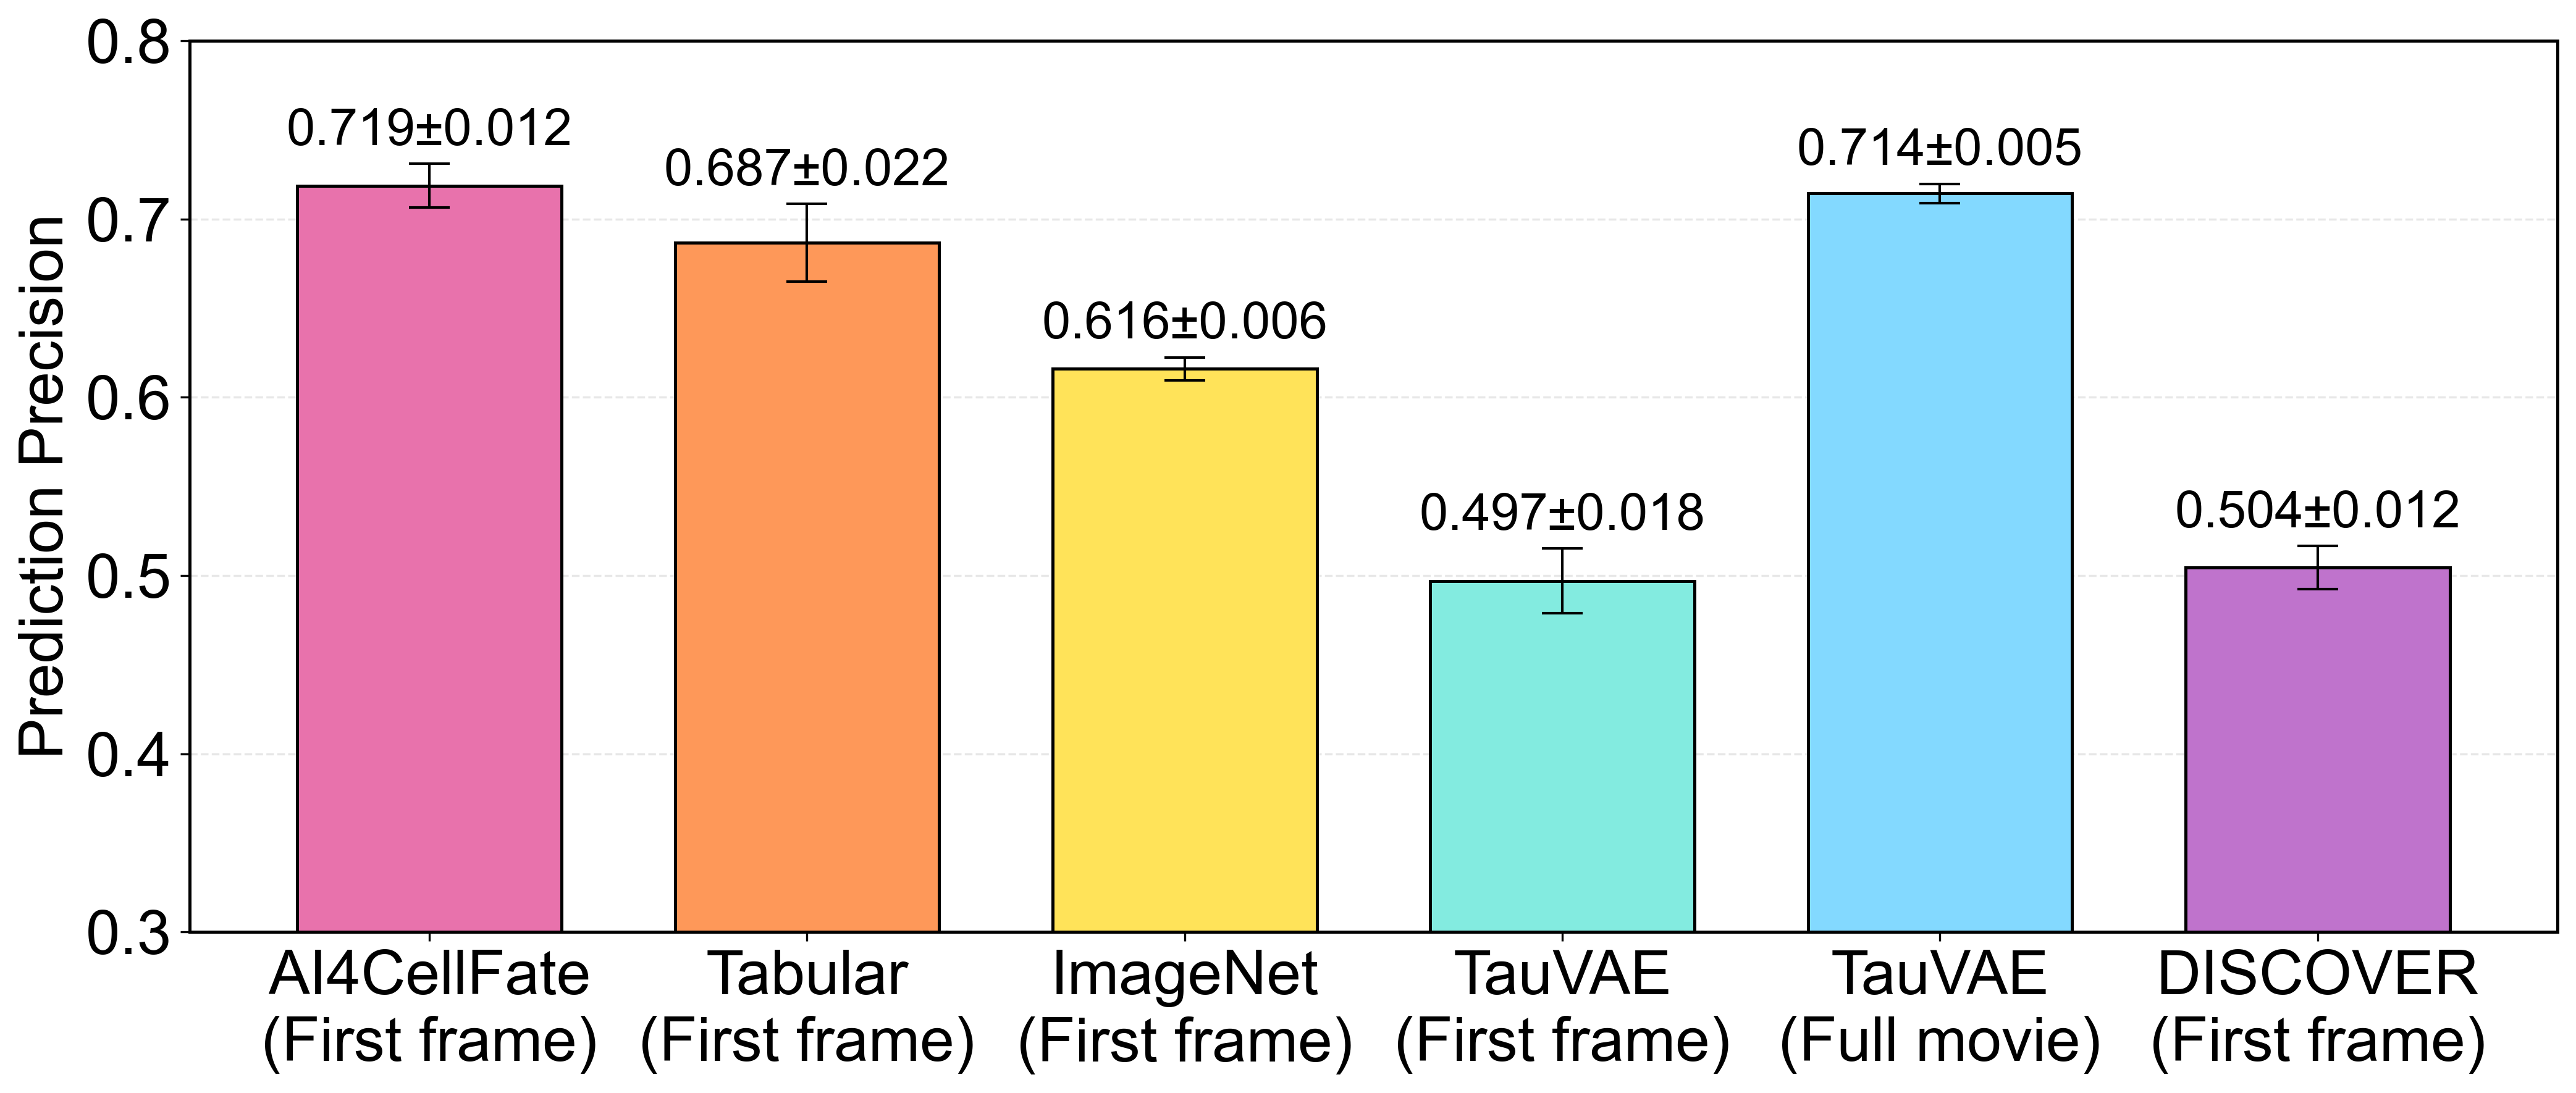

📊 Model Performance Summary:
AI4CellFate
(First frame): 0.7187 ± 0.0122
Tabular
(First frame): 0.6867 ± 0.0218
ImageNet
(First frame): 0.6159 ± 0.0064
TauVAE
(First frame): 0.4970 ± 0.0182
TauVAE
(Full movie): 0.7144 ± 0.0054
DISCOVER
(First frame): 0.5044 ± 0.0121


In [ ]:
model_names = [
    'AI4CellFate\n(First frame)', 'Tabular\n(First frame)', 'ImageNet\n(First frame)',
    'TauVAE\n(First frame)', 'TauVAE\n(Full movie)', 'DISCOVER\n(First frame)'
]

mean_precision = [precision_ai4cellfate.mean(), precision_tabular.mean(), precision_imagenet.mean(), precision_tauvae_single.mean(), precision_tauvae_movie.mean(), precision_discover.mean()]
std_precision = [precision_ai4cellfate.std(), precision_tabular.std(), precision_imagenet.std(), precision_tauvae_single.std(), precision_tauvae_movie.std(), precision_discover.std()]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)

# Define colors for each model
#colors = ['turquoise', 'orange', 'purple', 'magenta']  
#colors = ['#FE6100', '#DC267F', '#648FFF', '#FFB000', '#FFB000', '#FFB000']
colors = ["turquoise", "#DC267F", "#FE6100", "#FFB000", "green", "purple"] 
colors = ["turquoise", "#DC267F", "#FE6100", "#3D5AFE", "#2ED47A", "#9B5DE5"]
colors = ["#DC267F", "#FE6100", "#FFD400", "#00C853", "#1ABC9C", "#9C27B0"]
colors = ["#DC267F", "#FE6100", "#FFD400", "turquoise", "turquoise", "#9C27B0"]
colors = ["#DC267F", "#FE6100", "#FFD400", "turquoise", "#40C4FF", "#9C27B0"] #"#82B1FF", 

from matplotlib.colors import to_rgb

def lighten(hex_color, factor=0.6):
    # factor in (0,1): closer to 1 → lighter (blend toward white)
    r,g,b = to_rgb(hex_color)
    r = 1 - (1 - r)*factor
    g = 1 - (1 - g)*factor
    b = 1 - (1 - b)*factor
    return (r,g,b)

# Your base vibrant colors
base_colors = ["#DC267F", "#FE6100", "#FFD400", "turquoise", "#40C4FF", "#9C27B0"]
# Make them lighter instead of using alpha
colors = [lighten(c, 0.65) for c in base_colors]

bars = ax.bar(model_names, mean_precision, yerr=std_precision,
              capsize=8, width=0.7, color=colors, edgecolor='black',
              linewidth=1.2, error_kw={'elinewidth':1, 'ecolor':'black', 'capthick':1})
# #            pink       orange     yellow      TauVAE SF   TauVAE FM   violet
# bars = ax.bar(model_names, mean_precision, yerr=std_precision,
#               capsize=8, width=0.7, color=colors, alpha=0.2,
#               edgecolor='black', linewidth=1.2,
#               error_kw={'elinewidth': 1, 'ecolor': 'black', 'capthick': 1}, rasterized=True)


# Customize the plot
ax.set_ylabel('Prediction Precision', fontsize=24, fontweight='light', fontname='Arial')
#ax.set_title('Model Performance Comparison', fontsize=18, fontweight='bold', fontname='Arial')

# Set y-axis limits to better show differences
y_min = 0.3#min(means_accuracy) - max(std_accuracy) - 0.02
y_max = 0.8#max(means_accuracy) + max(std_accuracy) + 0.02
ax.set_ylim(y_min, y_max)

# Add value labels on top of bars
for i, (bar, mean, std) in enumerate(zip(bars, mean_precision, std_precision)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.005,
            f'{mean:.3f}±{std:.3f}',
            ha='center', va='bottom', fontsize=20, fontweight='light', fontname='Arial')

# Customize grid and spines
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
for spine in ax.spines.values():
    spine.set_linewidth(1.2)

# Rotate x-axis labels if needed and increase font size
ax.tick_params(axis='x', labelsize=24, labelrotation=0)
ax.tick_params(axis='y', labelsize=24)

# Set font for tick labels
for label in ax.get_xticklabels():
    label.set_fontname('Arial')
for label in ax.get_yticklabels():
    label.set_fontname('Arial')

plt.tight_layout()
#plt.savefig("Fig2E_state_of_the_art_bigalpha.eps", format="eps", dpi=300, bbox_inches="tight")
plt.show()

# Print summary statistics
print("📊 Model Performance Summary:")
print("=" * 50)
for name, mean, std in zip(model_names, mean_precision, std_precision):
    print(f"{name:12s}: {mean:.4f} ± {std:.4f}")